<a href="https://colab.research.google.com/github/ahwarkhan/DL-IID/blob/main/CICIDS2017__DL_IID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e800eff7a59b3e1a64ba9443de88941b3f1c5c1ee3f81bcfb0bf103f62c61972
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
import psutil
import time
import random
import math
import lime
import lime.lime_tabular

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/DDoS-17/DDoS.csv')

In [ ]:
dataset.describe().T

count          mean           std  min      25%  \
 Source Port        225745.0  3.825757e+04  2.305730e+04  0.0  18990.0   
 Destination Port   225745.0  8.879619e+03  1.975465e+04  0.0     80.0   
 Protocol           225745.0  7.600288e+00  3.881586e+00  0.0      6.0   
 Flow Duration      225745.0  1.624165e+07  3.152437e+07 -1.0  71180.0   
 Total Fwd Packets  225745.0  4.874916e+00  1.542287e+01  1.0      2.0   
...                      ...           ...           ...  ...      ...   
 Active Min         225745.0  1.776201e+05  7.842602e+05  0.0      0.0   
Idle Mean           225745.0  1.032214e+07  2.185303e+07  0.0      0.0   
 Idle Std           225745.0  3.611943e+06  1.275689e+07  0.0      0.0   
 Idle Max           225745.0  1.287813e+07  2.692126e+07  0.0      0.0   
 Idle Min           225745.0  7.755355e+06  1.983109e+07  0.0      0.0   

                          50%        75%          max  
 Source Port          49799.0    58296.0      65534.0  
 Destination Port        80.0       80.0      65532.0  
 Protocol                 6.0        6.0         17.0  
 Flow Duration      1452333.0  8805237.0  119999937.0  
 Total Fwd Packets        3.0        5.0       1932.0  
...                       ...        ...          ...  
 Active Min               0.0     1862.0  100000000.0  
Idle Mean                 0.0  8239725.0  120000000.0  
 Idle Std                 0.0        0.0   65300000.0  
 Idle Max                 0.0  8253838.0  120000000.0  
 Idle Min                 0.0  7422849.0  120000000.0  

[80 rows x 8 columns]

In [ ]:
dataset.head()

Flow ID       Source IP   Source Port  \
0  192.168.10.5-104.16.207.165-54865-443-6  104.16.207.165           443   
1    192.168.10.5-104.16.28.216-55054-80-6   104.16.28.216            80   
2    192.168.10.5-104.16.28.216-55055-80-6   104.16.28.216            80   
3  192.168.10.16-104.17.241.25-46236-443-6   104.17.241.25           443   
4  192.168.10.5-104.19.196.102-54863-443-6  104.19.196.102           443   

   Destination IP   Destination Port   Protocol      Timestamp  \
0    192.168.10.5              54865          6  7/7/2017 3:30   
1    192.168.10.5              55054          6  7/7/2017 3:30   
2    192.168.10.5              55055          6  7/7/2017 3:30   
3   192.168.10.16              46236          6  7/7/2017 3:30   
4    192.168.10.5              54863          6  7/7/2017 3:30   

    Flow Duration   Total Fwd Packets   Total Backward Packets  ...  \
0               3                   2                        0  ...   
1             109                   1                        1  ...   
2              52                   1                        1  ...   
3              34                   1                        1  ...   
4               3                   2                        0  ...   

    min_seg_size_forward  Active Mean   Active Std   Active Max   Active Min  \
0                     20          0.0          0.0            0            0   
1                     20          0.0          0.0            0            0   
2                     20          0.0          0.0            0            0   
3                     20          0.0          0.0            0            0   
4                     20          0.0          0.0            0            0   

   Idle Mean   Idle Std   Idle Max   Idle Min   Label  
0        0.0        0.0          0          0  BENIGN  
1        0.0        0.0          0          0  BENIGN  
2        0.0        0.0          0          0  BENIGN  
3        0.0        0.0          0          0  BENIGN  
4        0.0        0.0          0          0  BENIGN  

[5 rows x 85 columns]

In [ ]:
dataset.shape

(225745, 85)

In [ ]:
dataset.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
Idle Mean            0
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Length: 85, dtype: int64

In [ ]:
dataset.columns

Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [ ]:
dataset[' Label'].value_counts()

Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64

In [ ]:
X = dataset.drop([' Label'], axis=1)
y = dataset[' Label']

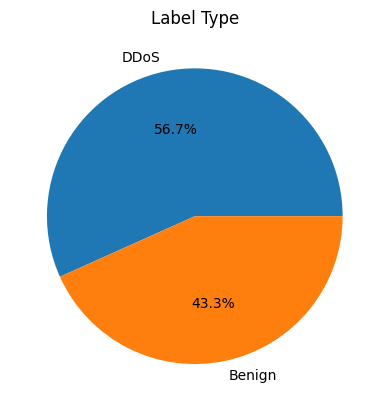

In [ ]:
graph_labels = 'DDoS', 'Benign'
graph_y = y.value_counts()
fig, ax = plt.subplots()
ax.pie(graph_y, labels=graph_labels, autopct='%1.1f%%')
plt.title('Label Type')
plt.show()

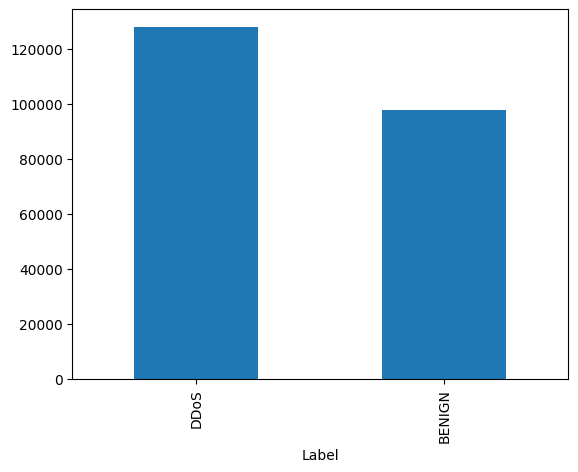

In [ ]:
graph_y.plot(kind='bar', xlabel='Label')
plt.show()

In [ ]:
X = X.replace([np.inf, -np.inf], np.nan)

In [ ]:
encoder = LabelEncoder()

for column in X.select_dtypes(include=['object']).columns:
  X[column] = encoder.fit_transform(X[column])
y = encoder.fit_transform(y)

In [ ]:
X.fillna(X.mean(), inplace=True)

In [ ]:
X.shape

(225745, 84)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        assert len(self.X) == len(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

In [ ]:
train_dataset = MyDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = MyDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
val_dataset = MyDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### DNN-BiLSTM

In [ ]:
class DNNBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, lstm_layers, output_size):
        super(DNNBiLSTM, self).__init__()

        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()

        self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size,
                            num_layers=lstm_layers, batch_first=True,
                            bidirectional=True)

        self.fc3 = nn.Linear(hidden_size * 2, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.float()
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]

        x = self.fc3(lstm_out)
        return self.softmax(x)

    def predict_proba(self, x):
      with torch.no_grad():
          x = torch.tensor(x, dtype=torch.float32)
          output = self.forward(x)
          probabilities = F.softmax(output, dim=1).numpy()
          return probabilities

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, correct_train, total_samples = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = (correct_train / total_samples) * 100

        # Validation Phase
        model.eval()
        total_val_loss, correct_val, total_val_samples = 0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                total_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val_samples += labels.size(0)

        val_loss = total_val_loss / len(val_loader)
        val_accuracy = (correct_val / total_val_samples) * 100

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [ ]:
def plot_performance(train_losses, val_losses, train_acc, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss Plot
    axes[0].plot(train_losses, label="Train Loss", color='blue')
    axes[0].plot(val_losses, label="Validation Loss", color='red')
    axes[0].set_title("Loss Curve")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Accuracy Plot
    axes[1].plot(train_acc, label="Train Accuracy", color='blue')
    axes[1].plot(val_acc, label="Validation Accuracy", color='red')
    axes[1].set_title("Accuracy Curve")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy (%)")
    axes[1].legend()

    plt.show()

In [ ]:
input_size = X_train.shape[1]
hidden_size = 64
lstm_layers = 1
output_size = 2
batch_size = 128
num_epochs = 20
learning_rate = 0.0001

In [ ]:
model = DNNBiLSTM(input_size, hidden_size, lstm_layers, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
train_losses, val_losses, train_acc, val_acc = train(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch 1/20 | Train Loss: 0.3384 | Val Loss: 0.3138 | Train Acc: 98.63% | Val Acc: 99.95%
Epoch 2/20 | Train Loss: 0.3139 | Val Loss: 0.3136 | Train Acc: 99.94% | Val Acc: 99.96%
Epoch 3/20 | Train Loss: 0.3139 | Val Loss: 0.3135 | Train Acc: 99.94% | Val Acc: 99.98%
Epoch 4/20 | Train Loss: 0.3138 | Val Loss: 0.3135 | Train Acc: 99.95% | Val Acc: 99.98%
Epoch 5/20 | Train Loss: 0.3138 | Val Loss: 0.3135 | Train Acc: 99.95% | Val Acc: 99.98%
Epoch 6/20 | Train Loss: 0.3138 | Val Loss: 0.3135 | Train Acc: 99.95% | Val Acc: 99.98%
Epoch 7/20 | Train Loss: 0.3137 | Val Loss: 0.3135 | Train Acc: 99.95% | Val Acc: 99.98%
Epoch 8/20 | Train Loss: 0.3138 | Val Loss: 0.3135 | Train Acc: 99.95% | Val Acc: 99.98%
Epoch 9/20 | Train Loss: 0.3138 | Val Loss: 0.3136 | Train Acc: 99.95% | Val Acc: 99.97%
Epoch 10/20 | Train Loss: 0.3138 | Val Loss: 0.3135 | Train Acc: 99.95% | Val Acc: 99.98%
Epoch 11/20 | Train Loss: 0.3137 | Val Loss: 0.3135 | Train Acc: 99.95% | Val Acc: 99.98%
Epoch 12/20 | Train

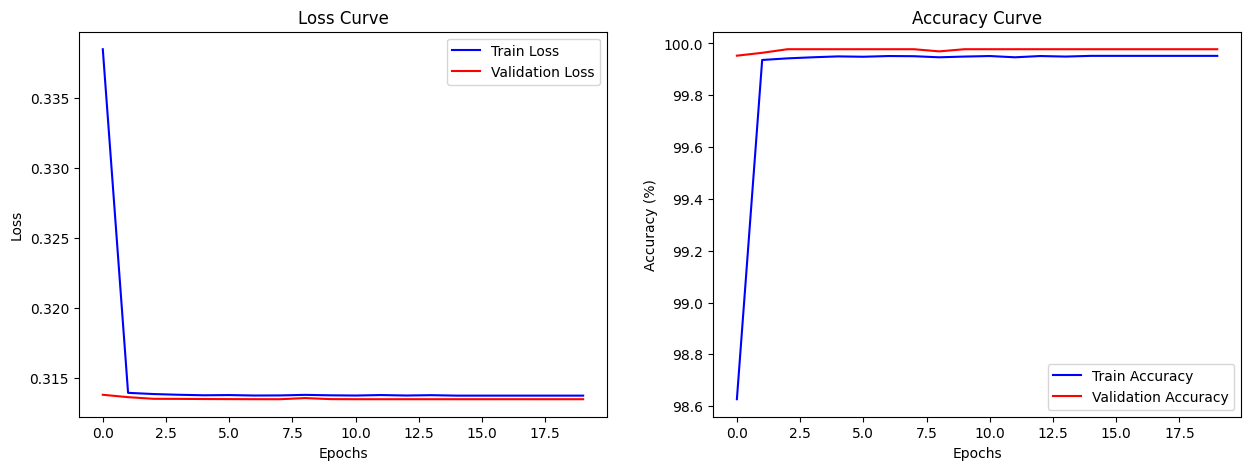

In [ ]:
plot_performance(train_losses, val_losses, train_acc, val_acc)

In [ ]:
def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    predictions = []
    labels = []

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device, dtype=torch.float32), y.to(device, dtype=torch.long)
            outputs = model(x)
            loss = criterion(outputs, y)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y).sum().item()

            predictions.extend(predicted.cpu().numpy())
            labels.extend(y.cpu().numpy())

    # Convert to numpy arrays
    labels_array = np.array(labels)
    predictions_array = np.array(predictions)

    # Compute evaluation metrics
    accuracy = correct / len(test_loader.dataset)
    precision = precision_score(labels, predictions, zero_division=False)
    recall = recall_score(labels, predictions, zero_division=False)
    f1 = f1_score(labels, predictions, zero_division=False)

    # Compute error metrics
    MSE = mean_squared_error(labels_array, predictions_array)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(labels_array, predictions_array)

    safe_labels = np.where(labels_array == 0, np.nan, labels_array)
    MAPE = np.nanmean(np.abs((labels_array - predictions_array) / safe_labels)) * 100

    # System Resource Utilization
    process = psutil.Process()
    cpu_utilization = psutil.cpu_percent(interval=1)
    memory_usage = process.memory_info().rss / 1024  # Convert to KB

    # Print Results
    print("\n--- Evaluation Metrics ---")
    print(f"Test Loss: {test_loss / len(test_loader):.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\n--- Error Metrics ---")
    print(f"Mean Absolute Error (MAE): {MAE:.4f}")
    print(f"Mean Squared Error (MSE): {MSE:.4f}")
    print(f"Root Mean Squared Error (RMSE): {RMSE:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {MAPE:.2f}%")

    print("\n--- System Resource Utilization ---")
    print(f"CPU Utilization: {cpu_utilization}%")
    print(f"Memory Usage: {memory_usage:.2f} KB")

    # Print Classification Report
    print("\n--- Classification Report ---")
    print(classification_report(labels, predictions, target_names=['Benign', 'DDoS']))

    # Plot Confusion Matrix
    conf_matrix = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Benign', 'DDoS'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


--- Evaluation Metrics ---
Test Loss: 0.3138
Test Accuracy: 0.9994
Precision: 1.0000
Recall: 0.9990
F1 Score: 0.9995

--- Error Metrics ---
Mean Absolute Error (MAE): 0.0006
Mean Squared Error (MSE): 0.0006
Root Mean Squared Error (RMSE): 0.0235
Mean Absolute Percentage Error (MAPE): 0.10%

--- System Resource Utilization ---
CPU Utilization: 2.5%
Memory Usage: 1273600.00 KB

--- Classification Report ---
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     19405
        DDoS       1.00      1.00      1.00     25744

    accuracy                           1.00     45149
   macro avg       1.00      1.00      1.00     45149
weighted avg       1.00      1.00      1.00     45149



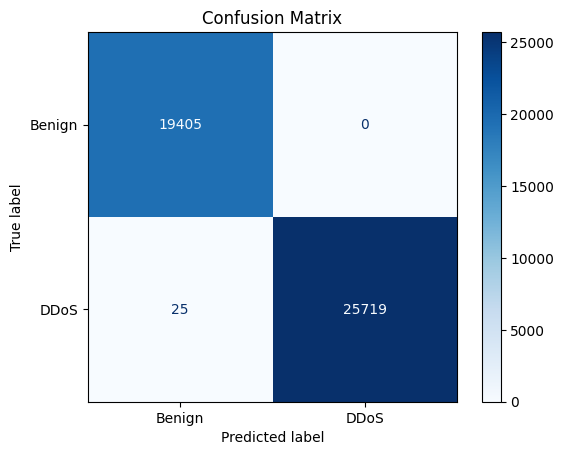

In [ ]:
evaluate_model(model, test_loader)

###Fitness (Objective) Function

In [ ]:
def train_on_selected_features(selected_features, X, y, epochs=50, batch_size=128):
    selected_features_indices = np.where(selected_features)[0]
    X_selected = X.iloc[:, selected_features_indices]

    scaler = StandardScaler()
    X_selected = scaler.fit_transform(X_selected)

    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    train_dataset1 = MyDataset(X_train, y_train)
    train_loader1 = DataLoader(train_dataset1, batch_size=64, shuffle=True)
    val_dataset1 = MyDataset(X_val, y_val)
    val_loader1 = DataLoader(val_dataset1, batch_size=64, shuffle=False)

    input_size = X_train.shape[1]
    hidden_size = 64
    lstm_layers = 1
    output_size = 2
    model = DNNBiLSTM(input_size, hidden_size, lstm_layers, output_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader1:
            x, y = batch
            y = y.long()
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        correct = 0

        with torch.no_grad():
            for batch in val_loader1:
                x, y = batch
                y = y.long()
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y).sum().item()

        accuracy = correct / len(val_dataset1)

        return 1 - accuracy

In [ ]:
class solution:
    def __init__(self):
        self.best = 0
        self.bestIndividual = []
        self.convergence = []
        self.optimizer = ""
        self.objfname = ""
        self.startTime = 0
        self.endTime = 0
        self.executionTime = 0
        self.lb = 0
        self.ub = 0
        self.dim = 0
        self.popnum = 0
        self.maxiers = 0

### GA

In [ ]:
def crossover(individualLength, parent1, parent2):
    crossover_point = random.randint(1, individualLength - 1)
    offspring1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
    offspring2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
    return offspring1, offspring2

In [ ]:
def mutation(individual, individualLength, lb, ub):
    mutationIndex = random.randint(0, individualLength - 1)
    individual[mutationIndex] = 1 - individual[mutationIndex]

In [ ]:
def pairSelection(population, scores, popSize):
    def rouletteWheelSelectionId(scores, popSize):
        total_fitness = sum(scores)
        normalized_scores = [score / total_fitness for score in scores]
        cumulative_probs = np.cumsum(normalized_scores)
        random_num = random.random()
        for i, cumulative_prob in enumerate(cumulative_probs):
            if random_num <= cumulative_prob:
                return i

    parent1Id = rouletteWheelSelectionId(scores, popSize)
    parent1 = population[parent1Id].copy()

    parent2Id = parent1Id
    while parent2Id == parent1Id:
        parent2Id = rouletteWheelSelectionId(scores, popSize)

    parent2 = population[parent2Id].copy()

    return parent1, parent2

In [ ]:
def mutatePopulaton(population, popSize, mutationProbability, keep, lb, ub):
    for i in range(keep, popSize):
        if random.random() < mutationProbability:
            mutation(population[i], len(population[i]), lb, ub)

In [ ]:
def sortPopulation(population, scores):
    sorted_indices = scores.argsort()
    population = population[sorted_indices]
    scores = scores[sorted_indices]
    return population, scores

In [ ]:
def crossoverPopulaton(population, scores, popSize, crossoverProbability, keep):
    newPopulation = np.zeros_like(population)
    newPopulation[:keep] = population[:keep]

    for i in range(keep, popSize, 2):
        parent1, parent2 = pairSelection(population, scores, popSize)
        individualLength = len(parent1)

        if random.random() < crossoverProbability:
            offspring1, offspring2 = crossover(individualLength, parent1, parent2)
        else:
            offspring1, offspring2 = parent1.copy(), parent2.copy()

        newPopulation[i] = offspring1
        if i + 1 < popSize:
            newPopulation[i + 1] = offspring2

    return newPopulation

In [ ]:
def clearDups(population, lb, ub):
    unique_population = np.unique(population, axis=0)
    num_duplicates = len(population) - len(unique_population)

    if num_duplicates > 0:
        random_individuals = np.random.randint(2, size=(num_duplicates, population.shape[1]))
        unique_population = np.vstack((unique_population, random_individuals))

    return unique_population

In [ ]:
def GA(objf, lb, ub, dim, popSize, iters):
    cp = 0.8
    mp = 0.05
    keep = 2
    s = solution()

    bestScore = float("inf")
    bestIndividual = None

    ga = np.random.randint(2, size=(popSize, dim))
    convergence_curve = np.zeros(iters)

    print('GA is optimizing "' + objf.__name__ + '" for feature selection')

    timerStart = time.time()
    s.startTime = time.strftime("%Y-%m-%d-%H-%M-%S")

    for l in range(iters):
        scores = np.array([objf(ind) for ind in ga])

        ga, scores = sortPopulation(ga, scores)

        if scores[0] < bestScore:
            bestScore = scores[0]
            bestIndividual = ga[0]

        convergence_curve[l] = bestScore

        if l % 1 == 0:
            print(f"Iteration {l + 1}, best fitness (error): {bestScore:.4f}")

        ga = crossoverPopulaton(ga, scores, popSize, cp, keep)
        mutatePopulaton(ga, popSize, mp, keep, lb, ub)
        ga = clearDups(ga, lb, ub)

    timerEnd = time.time()
    s.bestIndividual = bestIndividual
    s.bestScore = bestScore
    s.executionTime = timerEnd - timerStart
    s.convergence = convergence_curve
    s.optimizer = "GA"
    s.objfname = objf.__name__

    return s

In [ ]:
dim = X.shape[1]
lb = [0] * dim
ub = [1] * dim
popSize = 20
iters = 5

In [ ]:
def objective(selected_features):
  return train_on_selected_features(selected_features, X, y)

In [ ]:
best_solution = GA(objective, lb, ub, dim, popSize, iters)

print(f"Best feature set: {best_solution.bestIndividual}")
print(f"Best accuracy (1 - best error): {1 - best_solution.bestScore}")

GA is optimizing "objective" for feature selection
Iteration 1, best fitness (error): 0.0003
Iteration 2, best fitness (error): 0.0002
Iteration 3, best fitness (error): 0.0002
Iteration 4, best fitness (error): 0.0002
Iteration 5, best fitness (error): 0.0002
Best feature set: [1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0
 1 1 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1
 1 0 1 0 1 0 1 0 1 0]
Best accuracy (1 - best error): 0.9998062015503876


In [ ]:
selected_features_ga = best_solution.bestIndividual

In [ ]:
selected_features_ga

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

In [ ]:
selected_features_ga_original = [X.columns[i] for i, x in enumerate(selected_features_ga) if x == 1]
print(selected_features_ga_original)
print(len(selected_features_ga_original))

['Flow ID', ' Source IP', ' Source Port', ' Destination IP', ' Destination Port', ' Timestamp', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', 'Bwd Packet Length Max', ' Bwd Packet Length Mean', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', ' Bwd IAT Std', ' Bwd IAT Min', ' Bwd PSH Flags', ' Fwd URG Flags', ' Fwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Packet Length Std', ' Packet Length Variance', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag Count', ' Fwd Avg Packets/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate', ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Init_Win_bytes_backward', ' act_data_pkt_fwd', 'Active Mean', ' Active Max', 'Idle Mean', ' Idle Max']
49


In [ ]:
weights_ga = [1 if x in selected_features_ga_original else 0 for x in X.columns]
print(weights_ga)

[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


In [ ]:
selected_features_ga_original

['Flow ID',
 ' Source IP',
 ' Source Port',
 ' Destination IP',
 ' Destination Port',
 ' Timestamp',
 ' Total Fwd Packets',
 ' Total Backward Packets',
 'Total Length of Fwd Packets',
 ' Total Length of Bwd Packets',
 ' Fwd Packet Length Max',
 ' Fwd Packet Length Min',
 ' Fwd Packet Length Mean',
 'Bwd Packet Length Max',
 ' Bwd Packet Length Mean',
 ' Flow Packets/s',
 ' Flow IAT Mean',
 ' Flow IAT Std',
 ' Flow IAT Min',
 'Fwd IAT Total',
 ' Fwd IAT Mean',
 ' Fwd IAT Std',
 ' Fwd IAT Max',
 ' Fwd IAT Min',
 ' Bwd IAT Std',
 ' Bwd IAT Min',
 ' Bwd PSH Flags',
 ' Fwd URG Flags',
 ' Fwd Header Length',
 'Fwd Packets/s',
 ' Bwd Packets/s',
 ' Min Packet Length',
 ' Packet Length Std',
 ' Packet Length Variance',
 ' RST Flag Count',
 ' PSH Flag Count',
 ' ACK Flag Count',
 ' URG Flag Count',
 ' Fwd Avg Packets/Bulk',
 ' Bwd Avg Packets/Bulk',
 'Bwd Avg Bulk Rate',
 ' Subflow Fwd Bytes',
 ' Subflow Bwd Packets',
 ' Init_Win_bytes_backward',
 ' act_data_pkt_fwd',
 'Active Mean',
 ' Active 

### GA Features

In [ ]:
ga_features_indices = [X.columns.get_loc(col) for col in selected_features_ga_original]

In [ ]:
X_selected_ga = X.iloc[:, ga_features_indices]

In [ ]:
X_train_selected_ga, X_test_selected_ga, y_train_selected_ga, y_test_selected_ga = train_test_split(X_selected_ga, y, test_size=0.3, random_state=42)
X_train_selected_ga, X_val_selected_ga, y_train_selected_ga, y_val_selected_ga = train_test_split(X_train_selected_ga, y_train_selected_ga, test_size=0.2, random_state=42)

In [ ]:
X_train_selected_ga = scaler.fit_transform(X_train_selected_ga)
X_test_selected_ga = scaler.transform(X_test_selected_ga)
X_val_selected_ga = scaler.transform(X_val_selected_ga)

In [ ]:
train_dataset_selected_ga = MyDataset(X_train_selected_ga, y_train_selected_ga)
train_loader_selected_ga = DataLoader(train_dataset_selected_ga, batch_size=64, shuffle=True)
test_dataset_selected_ga = MyDataset(X_test_selected_ga, y_test_selected_ga)
test_loader_selected_ga = DataLoader(test_dataset_selected_ga, batch_size=64, shuffle=False)
val_dataset_selected_ga = MyDataset(X_val_selected_ga, y_val_selected_ga)
val_loader_selected_ga = DataLoader(val_dataset_selected_ga, batch_size=64, shuffle=False)

In [ ]:
model_selected_ga = DNNBiLSTM(input_size=X_train_selected_ga.shape[1], hidden_size=64, lstm_layers=1, output_size=2)
criterion = nn.CrossEntropyLoss()
optimizer_selected_ga = optim.Adam(model_selected_ga.parameters(), lr=0.0001)

In [ ]:
train_losses_selected_ga, val_losses_selected_ga, train_acc_selected_ga, val_acc_selected_ga = train(model_selected_ga, train_loader_selected_ga, val_loader_selected_ga, criterion, optimizer_selected_ga, num_epochs)

Epoch 1/20 | Train Loss: 0.3135 | Val Loss: 0.3133 | Train Acc: 99.98% | Val Acc: 100.00%
Epoch 2/20 | Train Loss: 0.3134 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 99.99%
Epoch 3/20 | Train Loss: 0.3134 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 100.00%
Epoch 4/20 | Train Loss: 0.3134 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 100.00%
Epoch 5/20 | Train Loss: 0.3133 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 100.00%
Epoch 6/20 | Train Loss: 0.3133 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 100.00%
Epoch 7/20 | Train Loss: 0.3133 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 100.00%
Epoch 8/20 | Train Loss: 0.3133 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 100.00%
Epoch 9/20 | Train Loss: 0.3133 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 100.00%
Epoch 10/20 | Train Loss: 0.3133 | Val Loss: 0.3133 | Train Acc: 99.99% | Val Acc: 100.00%
Epoch 11/20 | Train Loss: 0.3133 | Val Loss: 0.3133 | Train Acc: 100.00% | Val Acc: 99.99%
Epoch 12/

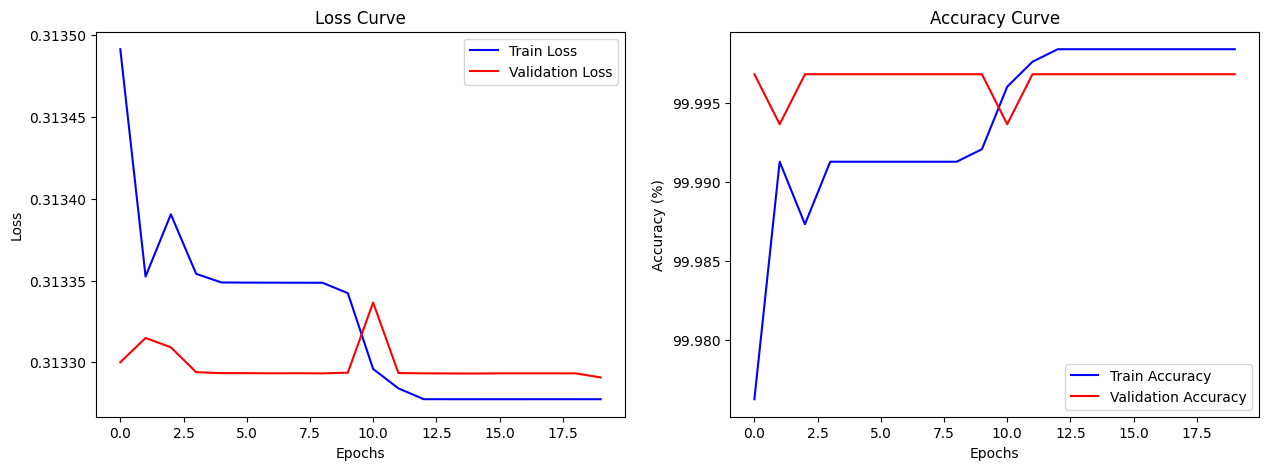

In [ ]:
plot_performance(train_losses_selected_ga, val_losses_selected_ga, train_acc_selected_ga, val_acc_selected_ga)


--- Evaluation Metrics ---
Test Loss: 0.3133
Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

--- Error Metrics ---
Mean Absolute Error (MAE): 0.0000
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0038
Mean Absolute Percentage Error (MAPE): 0.00%

--- System Resource Utilization ---
CPU Utilization: 4.0%
Memory Usage: 1586820.00 KB

--- Classification Report ---
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     29262
        DDoS       1.00      1.00      1.00     38462

    accuracy                           1.00     67724
   macro avg       1.00      1.00      1.00     67724
weighted avg       1.00      1.00      1.00     67724



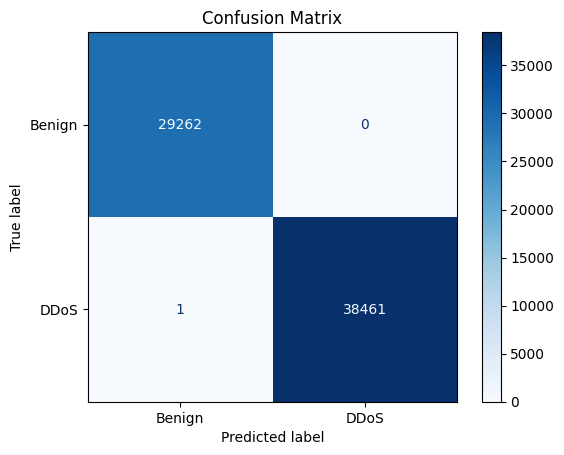

In [ ]:
evaluate_model(model_selected_ga, test_loader_selected_ga)

### LIME for DNN-BiLSTM with All Features

In [ ]:
explainer1 = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=X.columns.tolist(),
                                                   mode='classification',
                                                   discretize_continuous=True)

In [ ]:
i = 10
exp1 = explainer1.explain_instance(
    data_row=X_test[i],
    predict_fn=model.predict_proba,
    num_features=X_train.shape[1]
)

In [ ]:
y_test_selected_ga[i]

1

In [ ]:
exp1.show_in_notebook(show_table=True, show_predicted_value=True)

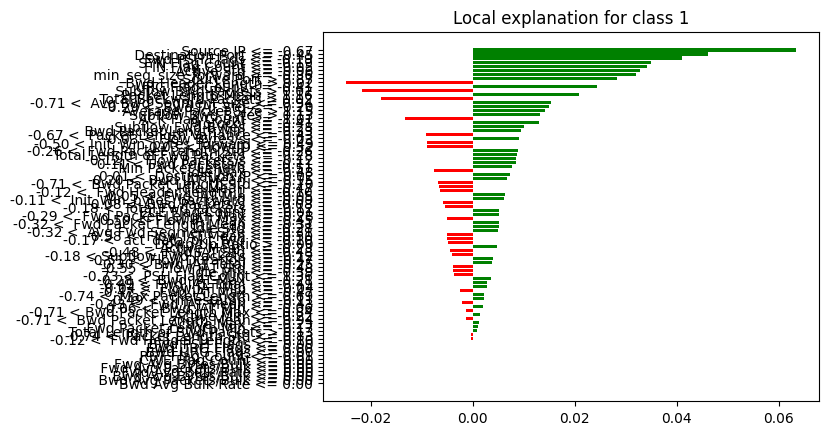

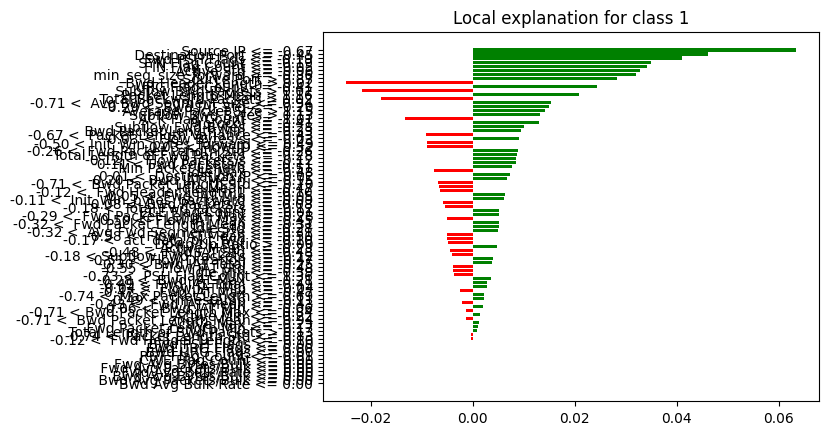

In [ ]:
exp1.as_pyplot_figure()

In [ ]:
feature_contributions1 = exp1.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions1)

Feature Contributions (index-based): [(1, 0.0634722433798905), (4, 0.04615963238312354), (36, 0.040999310042181235), (50, 0.03499246109686121), (49, 0.034140927675673685), (77, 0.03285124807958949), (75, 0.03208102314335517), (2, 0.02838948192835948), (41, -0.02493392064545968), (54, 0.024446724110987552), (70, -0.021790250316085714), (46, 0.02076416819141593), (9, -0.018011251738043143), (60, 0.015287259349466061), (33, 0.014976241359407514), (58, 0.014095472822733638), (71, 0.01325127243900773), (53, -0.01317448305741096), (5, 0.012937744788688699), (69, 0.010073982741273111), (17, 0.00949131570918121), (48, -0.009208672728184715), (20, 0.009076959434528445), (72, -0.009047425032759866), (0, -0.009015725618775628), (15, 0.00883431338911275), (10, 0.008774644652124896), (21, 0.00844779007660262), (42, 0.008424145433987578), (44, 0.007778941112206511), (82, -0.007511409534349888), (3, 0.007368746701754872), (32, 0.006790626829218945), (19, -0.006710948546169444), (80, -0.00664263208069

### LIME for DNN-BiLSTM with GA Features

In [ ]:
explainer2 = lime.lime_tabular.LimeTabularExplainer(X_train_selected_ga,
                                                   feature_names=X_selected_ga,
                                                   mode='classification',
                                                   discretize_continuous=True)

In [ ]:
j=10
exp2 = explainer2.explain_instance(
    data_row=X_test_selected_ga[j],
    predict_fn=model_selected_ga.predict_proba,
    num_features=X_train_selected_ga.shape[1]
)

In [ ]:
exp2.show_in_notebook(show_table=True, show_predicted_value=True)

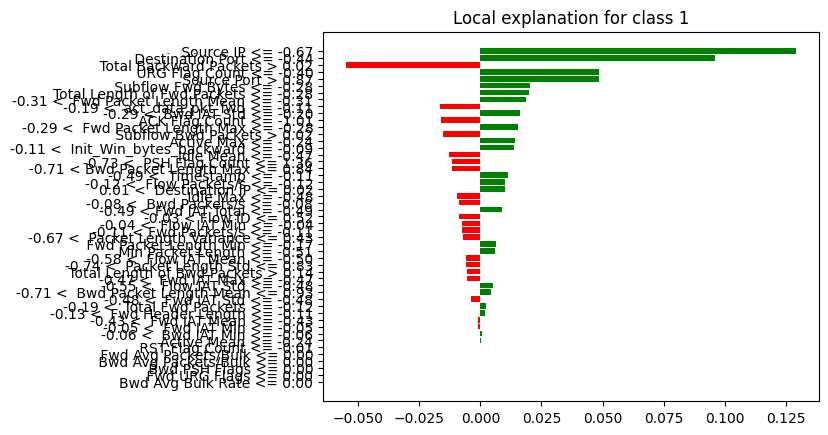

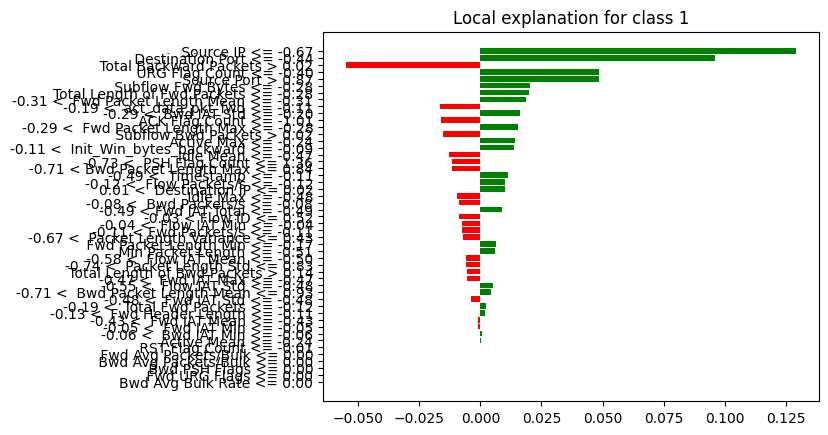

In [ ]:
exp2.as_pyplot_figure()

In [ ]:
feature_contributions2 = exp2.as_map()[1]
print("Feature Contributions (index-based):", feature_contributions2)

Feature Contributions (index-based): [(1, 0.12926204323660295), (4, 0.09584433257410888), (7, -0.0551292947800664), (37, 0.04854348249773819), (2, 0.04838652620711322), (41, 0.0202015928638809), (8, 0.019722808408794514), (12, 0.018554262466038172), (44, -0.016390869705980603), (24, 0.016376762697837263), (36, -0.01598476317710737), (10, 0.015457057085614965), (42, -0.015373092540240892), (46, 0.014275650137156171), (43, 0.013624229375903933), (47, -0.012639680905725715), (35, -0.011736257878972617), (13, -0.011447594179137748), (5, 0.011345984171872549), (15, 0.010048408169583384), (3, 0.009888290495396211), (48, -0.009651063774002688), (30, -0.008684090690883392), (19, 0.008674612893283681), (0, -0.008630029962591507), (18, -0.007599936602001052), (29, -0.007332400227065237), (33, -0.0070999254134755455), (11, 0.006468832542033772), (31, 0.006110343434762353), (16, -0.006060983445694473), (32, -0.005812375698678813), (9, -0.005332392605660137), (22, -0.005296378519426009), (17, 0.005

Model Size

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/research_paper/cicids_model.pth')

model_size1 = os.path.getsize('/content/drive/MyDrive/research_paper/cicids_model.pth') / 1024
print(f"Model Size: {model_size1:.2f} KB")

Model Size: 340.57 KB


In [ ]:
torch.save(model_selected_ga.state_dict(), '/content/drive/MyDrive/research_paper/cicids_ga_model.pth')

model_size_ga = os.path.getsize('/content/drive/MyDrive/research_paper/cicids_ga_model.pth') / 1024
print(f"Model Size: {model_size_ga:.2f} KB")

Model Size: 323.12 KB


### Dynamic Quantization model

In [ ]:
import torch.quantization
quantized_model_ga = torch.quantization.quantize_dynamic(
    model_selected_ga,
    {nn.LSTM},
    dtype=torch.qint8
)


--- Evaluation Metrics ---
Test Loss: 0.3133
Test Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

--- Error Metrics ---
Mean Absolute Error (MAE): 0.0000
Mean Squared Error (MSE): 0.0000
Root Mean Squared Error (RMSE): 0.0038
Mean Absolute Percentage Error (MAPE): 0.00%

--- System Resource Utilization ---
CPU Utilization: 92.5%
Memory Usage: 1596812.00 KB

--- Classification Report ---
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     29262
        DDoS       1.00      1.00      1.00     38462

    accuracy                           1.00     67724
   macro avg       1.00      1.00      1.00     67724
weighted avg       1.00      1.00      1.00     67724



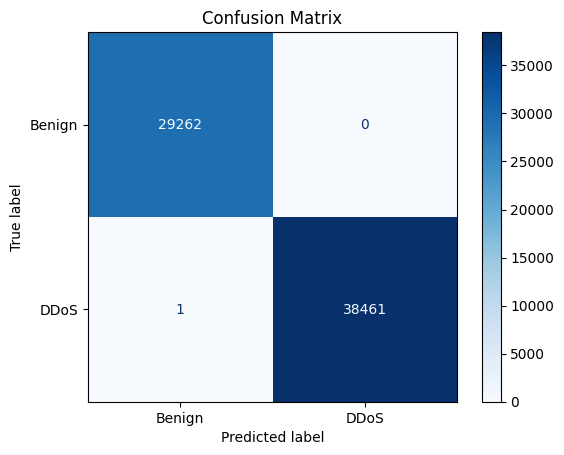

In [ ]:
evaluate_model(quantized_model_ga, test_loader_selected_ga)

In [ ]:
torch.save(quantized_model_ga.state_dict(), '/content/drive/MyDrive/research_paper/cicids_ga_quantised_model.pth')

quantized_ga_size = os.path.getsize('/content/drive/MyDrive/research_paper/cicids_ga_quantised_model.pth') / 1024
print(f"Model Size: {quantized_ga_size:.2f} KB")

Model Size: 132.11 KB
